# Using FEI's Offensive & Defensive Metrics to Analyze Correlations in Totals

For this project, I'm going to look at the totals record for a College Football team in a season and compare their efficiency in a given season. The goal is to compare offensive efficiency to overs, and defensive efficiencies to unders, and see if either of these metrics correlate to one another using regression analysis. Any guesses which one might be more correlated either positively or negatively?

Some limitations to this project includes the lack of game-by-game historical data as the total number for individual games are unknown for this aggregated data over each season. An example to illustrate this is a team could go 7-4 on the overs for a season, but have low totals for most games (think low 40s). A concrete example is from the 2022 Illinois team, which had the 3rd best adjusted defensive efficiency. Their over/under record? 8-5 or 61% to the over.... This is also usually the case for when the military academies play each other with totals right around 37 the past few games, and a couple even going over (despite the historical trend of academy unders cashing over 60% of the time). Said another way, the lower a team scores, the lower the bookmakers will make their total line.

We will see if there's any correlation between strong defenses and unders and strong offenses and overs. Knowing how Vegas operates, there could be a *negative* correlation because oddmakers might see a team perform so well defensively that they move the total for the following week too far in the other direction. With all that in mind let's dig into the stats. First, we must procure our data. Total numbers for the season are compliments of https://www.teamrankings.com/ncf/trends/, which is a great resource for some historic betting information. The efficiency numbers are from https://www.bcftoys.com/2022-fei/ which is also a great open source information for schedule adjusted efficiency stats.

In [238]:
# function to request the data and scrape it using BeautifulSoup

#    url = "https://www.teamrankings.com/ncf/trends/ou_trends/?range=yearly_"+str(x)
def CFB_07_22(url):

    response = requests.get(url)

    # Create a BeautifulSoup object to parse the HTML content
    soup = BeautifulSoup(response.text, "html.parser")

    # Find the table element containing the data
    table = soup.find("table")

    # Extract the table rows
    column_headers = [th.get_text(strip=True) for th in soup.select('thead th')]
    rows = table.find_all("tr")[1:]
    # Exclude the header row


    # Extract the data from each row
    content =[]
    
    for row in rows:
        columns = row.find_all('td')
        data = [column.get_text(strip=True) for column in columns]
        content.append(data)


    # Create a pandas DataFrame from the extracted data
    data = pd.DataFrame(content, columns=column_headers)
    
    return data

In [115]:
# creating a list of the years we wish to include in our dataset

years = [x for x in range(2007,2023)]
years

[2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

In [379]:
df = pd.DataFrame()
for x in years:
    url = "https://www.teamrankings.com/ncf/trends/ou_trends/?range=yearly_"+str(x)
    z =  CFB_07_22(url)
    z['Year'] = x
    df = df.append(z)

2023-07-07 10:22:00 [urllib3.connectionpool] DEBUG: Starting new HTTPS connection (1): www.teamrankings.com:443
2023-07-07 10:22:01 [urllib3.connectionpool] DEBUG: https://www.teamrankings.com:443 "GET /ncf/trends/ou_trends/?range=yearly_2007 HTTP/1.1" 200 None
2023-07-07 10:22:02 [urllib3.connectionpool] DEBUG: Starting new HTTPS connection (1): www.teamrankings.com:443
2023-07-07 10:22:02 [urllib3.connectionpool] DEBUG: https://www.teamrankings.com:443 "GET /ncf/trends/ou_trends/?range=yearly_2008 HTTP/1.1" 200 None
2023-07-07 10:22:03 [urllib3.connectionpool] DEBUG: Starting new HTTPS connection (1): www.teamrankings.com:443
2023-07-07 10:22:03 [urllib3.connectionpool] DEBUG: https://www.teamrankings.com:443 "GET /ncf/trends/ou_trends/?range=yearly_2009 HTTP/1.1" 200 None
2023-07-07 10:22:03 [urllib3.connectionpool] DEBUG: Starting new HTTPS connection (1): www.teamrankings.com:443
2023-07-07 10:22:04 [urllib3.connectionpool] DEBUG: https://www.teamrankings.com:443 "GET /ncf/trends/

In [380]:
df.head()

,Team,Over Record,Over %,Under %,Total +/-,Year
0,Rice,10-1-0,90.9%,9.1%,+11.8,2007
1,Florida,10-2-0,83.3%,16.7%,+13.3,2007
2,Central Mich,10-3-0,76.9%,23.1%,+10.6,2007
3,Ohio,8-3-0,72.7%,27.3%,+10.0,2007
4,Toledo,8-3-0,72.7%,27.3%,+10.6,2007


In [381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083 entries, 0 to 132
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Team         2083 non-null   object
 1   Over Record  2083 non-null   object
 2   Over %       2083 non-null   object
 3   Under %      2083 non-null   object
 4   Total +/-    2083 non-null   object
 5   Year         2083 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 113.9+ KB


In [382]:
print("There should be ",(2023-2007)*133, " College Football Teams total from 2007-2022")

There should be  2128  College Football Teams total from 2007-2022


Looks like we are missing a couple teams from the past, but we will not worry about that for the time being. One thing we will need to do is examine the names of our teams and replace the names of some of our rows so that we can seamlessly join them when the time is right.

We will do this by performing a "isin" method onto our dataframe to see which teams "are in" our other dataframe and which ones aren't. Those that are not we will have to manuelly adjust in our loop.

In [384]:
# Using groupby to ensure our data rows are all the standard 133 teams for each year

df.groupby(['Year']).count()

,Team,Over Record,Over %,Under %,Total +/-
Year,,,,,
2007,127,127,127,127,127
2008,127,127,127,127,127
2009,128,128,128,128,128
2010,129,129,129,129,129
2011,130,130,130,130,130
2012,131,131,131,131,131
2013,132,132,132,132,132
2014,131,131,131,131,131
2015,131,131,131,131,131


One reason for the increase in FBS schools is more schools joining the FBS similar to James Madison last year, and Sam Houston and Jacksonville State this year. However, the amount does not add up. At this point, I think we should just focus on the specific team names and ensuring those are properly spelled so that we can perform an inner join with the data and correct rows we have. 

So our table, at least the top and bottom, look as it should. Pretty fun way to copy a bunch of information from the internet. Now lets get our FEI from the website:

    • https://www.bcftoys.com/2022-fei/

In [385]:
def FEI_07_22(url):

    response = requests.get(url)

    # Create a BeautifulSoup object to parse the HTML content
    soup = BeautifulSoup(response.text, "html.parser")

    # Find the table containing the data
    table = soup.find('table')

    # Find all rows in the table body
    rows = table.find('tbody').find_all('tr')

    # List to store the extracted data
    data = []

    # Extract data from each row
    for row in rows:
        # Find all cells in the row
        cells = row.find_all('td')

        # try and except for error handling for whenever an individual row data can't be indexed
        try:

            # Extract the desired data from each cell
            rank = cells[0].text.strip()
            team = cells[1].text.strip()
            record = cells[2].text.strip()
            fbs = cells[3].text.strip()
            fei = cells[4].text.strip()
            ofei = cells[6].text.strip()
            dfei = cells[8].text.strip()
            nde = cells[11].text.strip()
            npd = cells[13].text.strip()
            nay = cells[15].text.strip()
            npp = cells[17].text.strip()
            els = cells[20].text.strip()
            gls = cells[22].text.strip()
            als = cells[24].text.strip()

        except IndexError:
            continue
        # Create a dictionary for the row data
        row_data = {
            'Rank': rank,
            'Team': team,
            'Record': record,
            'FBS': fbs,
            'FEI': fei,
            'OFEI': ofei,
            'DFEI': dfei,
            'NDE': nde,
            'NPD': npd,
            'NAY': nay,
            'NPP': npp,
            'ELS': els,
            'GLS': gls,
            'ALS': als
        }

        # Append the dictionary to the data list
        data.append(row_data)

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)
    
    # Remove the first row (header row)
    df = df.iloc[1:]

    # Reset the index of the DataFrame
    df = df.reset_index(drop=True)

    return df

In [175]:
reverse_years = years[::-1]
reverse_years

[2022,
 2021,
 2020,
 2019,
 2018,
 2017,
 2016,
 2015,
 2014,
 2013,
 2012,
 2011,
 2010,
 2009,
 2008,
 2007]

In [414]:
# Create a loop to get every year from 2007-2022 of the efficiency data

df_fei = pd.DataFrame()
for x in reverse_years:
    url = "https://www.bcftoys.com/" + str(x) + "-fei/"
    try: 
        z = FEI_07_22(url)
    except AttributeError: 
        continue
    z['Year'] = x
    df_fei = df_fei.append(z)

2023-07-07 10:41:14 [urllib3.connectionpool] DEBUG: Starting new HTTPS connection (1): www.bcftoys.com:443
2023-07-07 10:41:14 [urllib3.connectionpool] DEBUG: https://www.bcftoys.com:443 "GET /2022-fei/ HTTP/1.1" 302 0
2023-07-07 10:41:14 [urllib3.connectionpool] DEBUG: Starting new HTTP connection (1): www.bcftoys.com:80
2023-07-07 10:41:14 [urllib3.connectionpool] DEBUG: http://www.bcftoys.com:80 "GET /2022-fei/;jsessionid=7C8C83C31B18E66FBEDBD6CB81D8F73A.v5-web005 HTTP/1.1" 200 None
2023-07-07 10:41:15 [urllib3.connectionpool] DEBUG: Starting new HTTPS connection (1): www.bcftoys.com:443
2023-07-07 10:41:15 [urllib3.connectionpool] DEBUG: https://www.bcftoys.com:443 "GET /2021-fei/ HTTP/1.1" 302 0
2023-07-07 10:41:15 [urllib3.connectionpool] DEBUG: Starting new HTTP connection (1): www.bcftoys.com:80
2023-07-07 10:41:15 [urllib3.connectionpool] DEBUG: http://www.bcftoys.com:80 "GET /2021-fei/;jsessionid=179A96049B805C0D57E9E0F43EF73F38.v5-web006 HTTP/1.1" 200 None
2023-07-07 10:41:1

In [415]:
# Using a groupby method to see which teams we have in which years

df_fei.groupby(['Year']).count()

,Rank,Team,Record,FBS,FEI,OFEI,DFEI,NDE,NPD,NAY,NPP,ELS,GLS,ALS
Year,,,,,,,,,,,,,,
2008,127,127,127,127,127,127,127,127,127,127,127,127,127,127
2009,127,127,127,127,127,127,127,127,127,127,127,127,127,127
2010,127,127,127,127,127,127,127,127,127,127,127,127,127,127
2011,127,127,127,127,127,127,127,127,127,127,127,127,127,127
2012,132,132,132,132,132,132,132,132,132,132,132,132,132,132
2013,133,133,133,133,133,133,133,133,133,133,133,133,133,133
2014,136,136,136,136,136,136,136,136,136,136,136,136,136,136
2015,136,136,136,136,136,136,136,136,136,136,136,136,136,136
2016,136,136,136,136,136,136,136,136,136,136,136,136,136,136


In [416]:
df_fei.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 126
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rank    2007 non-null   object
 1   Team    2007 non-null   object
 2   Record  2007 non-null   object
 3   FBS     2007 non-null   object
 4   FEI     2007 non-null   object
 5   OFEI    2007 non-null   object
 6   DFEI    2007 non-null   object
 7   NDE     2007 non-null   object
 8   NPD     2007 non-null   object
 9   NAY     2007 non-null   object
 10  NPP     2007 non-null   object
 11  ELS     2007 non-null   object
 12  GLS     2007 non-null   object
 13  ALS     2007 non-null   object
 14  Year    2007 non-null   int64 
dtypes: int64(1), object(14)
memory usage: 250.9+ KB


We missed a couple of columns from our original query, so let's just grab the other columns separatly.

In [417]:
# Performing 2007 separately because we did not get our 2012 FEI information above for whatever reason

url = 'https://www.bcftoys.com/2007-fei'
response = requests.get(url)

    # Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.text, "html.parser")

    # Find the table containing the data
table = soup.find('table')

    # Find all rows in the table body
rows = table.find('tbody').find_all('tr')

data = []
Year = 2007

for row in rows:
        # Find all cells in the row
    cells = row.find_all('td')

        # try and except for error handling for whenever an individual row data can't be indexed

    try:        # Extract the desired data from each cell
        rank = cells[0].text.strip()
        team = cells[1].text.strip()
        record = cells[2].text.strip()
        fbs = cells[3].text.strip()
        fei = cells[4].text.strip()
        ofei = cells[6].text.strip()
        dfei = cells[8].text.strip()
        nde = cells[11].text.strip()
        npd = cells[13].text.strip()
        nay = cells[15].text.strip()
        npp = cells[17].text.strip()
        els = cells[20].text.strip()
        gls = cells[22].text.strip()
        als = cells[24].text.strip()        
    
    except IndexError:
           continue
    
    # Create a dictionary for the row data           
    row_data = {
                'Rank': rank,
                'Team': team,
                'Record': record,
                'FBS': fbs,
                'FEI': fei,
                'OFEI': ofei,
                'DFEI': dfei,
                'NDE': nde,
                'NPD': npd,
                'NAY': nay,
                'NPP': npp,
                'ELS': els,
                'GLS': gls,
                'ALS': als,
                'Year': Year
            }

            # Append the dictionary to the data list
    data.append(row_data)
    

        # Create a DataFrame from the data list
    df_fei_2007 = pd.DataFrame(data)

    # Getting rid of the top header row
df_fei_2007 = df_fei_2007.iloc[1:]
    # 
df_fei = df_fei.append(df_fei_2007)
df_fei.info()

2023-07-07 10:43:16 [urllib3.connectionpool] DEBUG: Starting new HTTPS connection (1): www.bcftoys.com:443
2023-07-07 10:43:16 [urllib3.connectionpool] DEBUG: https://www.bcftoys.com:443 "GET /2007-fei HTTP/1.1" 302 0
2023-07-07 10:43:16 [urllib3.connectionpool] DEBUG: Starting new HTTP connection (1): www.bcftoys.com:80
2023-07-07 10:43:17 [urllib3.connectionpool] DEBUG: http://www.bcftoys.com:80 "GET /2007-fei;jsessionid=2B6517AA9CF7236565725B159DF467D7.v5-web020 HTTP/1.1" 200 None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2010 entries, 0 to 126
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rank    2010 non-null   object
 1   Team    2010 non-null   object
 2   Record  2010 non-null   object
 3   FBS     2010 non-null   object
 4   FEI     2010 non-null   object
 5   OFEI    2010 non-null   object
 6   DFEI    2010 non-null   object
 7   NDE     2010 non-null   object
 8   NPD     2010 non-null   object
 9   NAY     2010 non-null   object
 10  NPP     2010 non-null   object
 11  ELS     2010 non-null   object
 12  GLS     2010 non-null   object
 13  ALS     2010 non-null   object
 14  Year    2010 non-null   int64 
dtypes: int64(1), object(14)
memory usage: 251.2+ KB


In [393]:
# Omitting the columns that are not a team but a copy of the header

df_fei = df_fei[df_fei['Rank'] != 'Rk']

# Combining our data? Not so fast!

Now that all our rows are showing the data we want, we need to join the columns. The tricky part here is that because there's so many College Football programs, our joins will only work if the Team name is exact. So in order to combine these we will have to find out from our tables which ones can be combined and cannot. We will do this by performing a right join on both and seeing which Team names remain after the join. Once we have those, we can manually adjust each column. 

To make the list less scary we will subset our data to just the year 2012. We will assume that the different spellings of each name are consistent for each year, thus for sake of simplifying the problem we will start with just year 2012.

In [423]:
import re

# Define the replacement patterns and replacements
patterns = {
    r'\bSt\b': 'State',
    r'\bW\b': 'Western',
    r'\bE\b': 'Eastern',
    r'\bS\b': 'South',
    r'\bN\b': 'Northern'
}

# Define a function to apply the replacements
def replace_team_names(team_name):
    for pattern, replacement in patterns.items():
        team_name = re.sub(pattern, replacement, team_name)
    return team_name

# Apply the replacements to the 'Team' column in both dataframes
df_fei['Team'] = df_fei['Team'].apply(replace_team_names)
df['Team'] = df['Team'].apply(replace_team_names)

In [356]:
df_2012['Team'] = df_2012['Team'].apply(replace_team_names)
df_fei_2012['Team'] = df_fei_2012['Team'].apply(replace_team_names)

2023-07-06 20:40:39 [py.warnings] WARNING: <ipython-input-356-fb36351463ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2012['Team'] = df_2012['Team'].apply(replace_team_names)

2023-07-06 20:40:39 [py.warnings] WARNING: <ipython-input-356-fb36351463ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fei_2012['Team'] = df_fei_2012['Team'].apply(replace_team_names)



In [460]:
# Subset our data by year to make the visual easier
df_2012 = df[df['Year'] == 2012]
df_fei_2012 = df_fei[df_fei['Year'] == 2012]

# Check if team names from df_2012 are present in df_fei_2012
mask = df_fei_2012['Team'].isin(df_2012['Team'])

# Filter df_fei_2012 to get rows with different spellings
mismatched_teams_fei = df_fei_2012[~mask]['Team']

# Check if team names from df_fei_2012 are present in df_2012
mask_fei = df_2012['Team'].isin(df_fei_2012['Team'])

# Filter df_2012 to get rows with different spellings
mismatched_teams_over_under = df_2012[~mask_fei]['Team']

# Sort the mismatched teams alphabetically
mismatched_teams_over_under_sorted = sorted(mismatched_teams_over_under, key=lambda x: x[0])
mismatched_teams_fei_sorted = sorted(mismatched_teams_fei, key=lambda x: x[0])

# Print the mismatched team names side by side
for team1, team2 in zip(mismatched_teams_over_under_sorted,mismatched_teams_fei_sorted):
    print(team1,' : ',team2)

# We know our one dataset contains more points than the other so we can print those remaining 
length = int(len(mismatched_teams_fei_sorted))
print(mismatched_teams_over_under_sorted[length:])

	James Madison  :  Idaho
Appalachian State  :  Miami
Coastal Carolina  :  Southern Mississippi
['Georgia Southern', 'Georgia State', 'Jacksonville State', 'Liberty', 'Miami (FL)', 'Southern Ole Miss', 'Sam Hous State']


In [461]:
for team1, team2 in zip(mismatched_teams_over_under_sorted,mismatched_teams_fei_sorted):
    print(team1,' : ',team2)

print(mismatched_teams_over_under_sorted[length:])

	James Madison  :  Idaho
Appalachian State  :  Miami
Coastal Carolina  :  Southern Mississippi
['Georgia Southern', 'Georgia State', 'Jacksonville State', 'Liberty', 'Miami (FL)', 'Southern Ole Miss', 'Sam Hous State']


In [426]:
# Replacing our row values so that the team names are the same
df['Team'].replace({'Boston Col': 'Boston College','Bowling Grn': 'Bowling Green','Central Mich': 'Central Michigan',
                                'Central FL':'UCF','Eastern Carolina': 'East Carolina','Florida Intl': 'Florida International',
                                'Fla Atlantic':'Florida Atlantic','GA Tech':'Georgia Tech','LA Tech':'Louisiana Tech','LA Monroe':'UL Monroe',
                                'LA Lafayette': 'Louisiana','Miami (FL)':'Miami','Mississippi':'Ole Miss','Middle Tenn':'Middle Tennessee',
                                'Miss State':'Mississippi State', 'Northern Carolina':'North Carolina','Northern Mex State':'New Mexico State',
                                'Southern Carolina': 'South Carolina','Southern Methodist':'SMU','Southern Alabama':'South Alabama',
                                'Southern Florida':'South Florida','TX-San Ant':'UTSA','TX El Paso':'UTEP','TX Christian':'TCU',
                                'U Mass':'Massachusetts','VA Tech':'Virginia Tech','Wash State':'Washington State', 'Western Virginia':'West Virginia',
                                'App State': 'Appalachian State','GA Southern':'Georgia Southern','James Mad':'	James Madison', 'Coastal Car':'Coastal Carolina'
                                }, regex=True, inplace=True)


We have to see if our replacing of the row values will be enough to join our columns together. Again, we will use a subset of our original dataframes for computational efficiency.

In [427]:
# Subset our data by year to make the visual easier
df_2014 = df[df['Year'] == 2014]
df_fei_2014 = df_fei[df_fei['Year'] == 2014]

# Check if team names from df_2012 are present in df_fei_2012
mask = df_fei_2014['Team'].isin(df_2014['Team'])

# Filter df_fei_2012 to get rows with different spellings
mismatched_teams_fei = df_fei_2014[~mask]['Team']

# Check if team names from df_fei_2012 are present in df_2012
mask_fei = df_2014['Team'].isin(df_fei_2014['Team'])

# Filter df_2012 to get rows with different spellings
mismatched_teams_over_under = df_2014[~mask_fei]['Team']

# Sort the mismatched teams alphabetically
mismatched_teams_over_under_sorted = sorted(mismatched_teams_over_under, key=lambda x: x[0])
mismatched_teams_fei_sorted = sorted(mismatched_teams_fei, key=lambda x: x[0])

# Print the mismatched team names side by side
for team1, team2 in zip(mismatched_teams_over_under_sorted,mismatched_teams_fei_sorted):
    print('O/U Dataset: ',team1, '        FEI Dataset: ',team2)
length = int(len(mismatched_teams_fei_sorted))
print(mismatched_teams_over_under_sorted[length:])

O/U Dataset:  	James Madison         FEI Dataset:  Idaho
O/U Dataset:  Jacksonville State         FEI Dataset:  Miami
O/U Dataset:  Liberty         FEI Dataset:  Southern Mississippi
['Miami (FL)', 'Southern Ole Miss', 'Sam Hous State']


In [428]:
merged_df = pd.merge(df, df_fei, left_on=['Team', 'Year'], right_on=['Team', 'Year'], how='inner')
merged_df.head(25)

,Team,Over Record,Over %,Under %,Total +/-,Year,Rank,Record,FBS,FEI,OFEI,DFEI,NDE,NPD,NAY,NPP,ELS,GLS,ALS
0,Rice,10-1-0,90.9%,9.1%,+11.8,2007,107,3-9,3-8,-.67,-.73,-.69,-.98,-1.08,-.106,-1.07,.34,1.33,3.83
1,Florida,10-2-0,83.3%,16.7%,+13.3,2007,4,9-4,8-4,.91,1.50,.29,1.13,1.15,.114,1.28,1.12,4.32,8.67
2,Central Michigan,10-3-0,76.9%,23.1%,+10.6,2007,78,8-6,8-5,-.25,.10,-.57,.14,.17,-.006,-.10,.55,1.81,4.30
3,Ohio,8-3-0,72.7%,27.3%,+10.0,2007,94,6-6,5-6,-.54,-.97,-.29,-.31,-.19,-.071,-.32,.23,.61,2.04
4,Toledo,8-3-0,72.7%,27.3%,+10.6,2007,98,5-7,4-7,-.56,-.49,-.81,-.70,-.75,-.072,-.78,.37,1.10,3.27
5,Kansas State,8-3-0,72.7%,27.3%,+8.9,2007,51,5-7,4-7,.16,-.40,.54,-.20,-.10,-.013,-.38,.97,3.32,6.59
6,LSU,9-4-1,69.2%,30.8%,+7.9,2007,3,12-2,12-2,.93,.50,1.39,1.43,1.48,.163,.97,1.33,4.80,9.23
7,Florida Atlantic,9-4-0,69.2%,30.8%,+6.1,2007,76,8-5,8-5,-.21,-.48,.34,.13,.07,-.015,.44,.75,2.42,5.23
8,Washington,9-4-0,69.2%,30.8%,+4.8,2007,42,4-9,4-9,.21,-.01,.44,-.23,-.22,-.046,-.45,1.11,4.38,8.93
9,Texas,9-4-0,69.2%,30.8%,+5.2,2007,16,10-3,10-3,.55,.27,.75,.82,.85,.110,1.12,.78,3.17,7.25


We will take this part to manually check our information to make sure that it did join successfully. Like I said, this is a manual process so we will pick a couple data points from the top and bottom and ensure that it matches the data in both the websites we scraped.

In [431]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 0 to 1965
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Team         1966 non-null   object
 1   Over Record  1966 non-null   object
 2   Over %       1966 non-null   object
 3   Under %      1966 non-null   object
 4   Total +/-    1966 non-null   object
 5   Year         1966 non-null   int64 
 6   Rank         1966 non-null   object
 7   Record       1966 non-null   object
 8   FBS          1966 non-null   object
 9   FEI          1966 non-null   object
 10  OFEI         1966 non-null   object
 11  DFEI         1966 non-null   object
 12  NDE          1966 non-null   object
 13  NPD          1966 non-null   object
 14  NAY          1966 non-null   object
 15  NPP          1966 non-null   object
 16  ELS          1966 non-null   object
 17  GLS          1966 non-null   object
 18  ALS          1966 non-null   object
dtypes: int64(1), object(18)
mem

In [430]:
merged_df.tail(25)

,Team,Over Record,Over %,Under %,Total +/-,Year,Rank,Record,FBS,FEI,OFEI,DFEI,NDE,NPD,NAY,NPP,ELS,GLS,ALS
1941,Utah State,5-8-0,38.5%,61.5%,-0.7,2022,108,6-7,6-6,-.55,-.64,-.63,-.71,-.65,-.065,-.91,.71,1.80,4.29
1942,SMU,5-8-0,38.5%,61.5%,+4.7,2022,57,7-6,6-6,.14,.86,-.50,.14,.07,.043,.06,.54,2.68,6.75
1943,Michigan,5-8-1,38.5%,61.5%,+2.4,2022,5,13-1,13-1,1.14,1.25,1.01,1.96,2.10,.269,2.33,1.47,4.06,7.65
1944,Georgia Tech,4-7-1,36.4%,63.6%,-7.0,2022,92,5-7,4-7,-.33,-.69,.24,-.97,-1.07,-.161,-.89,1.45,3.69,7.06
1945,Connecticut,4-7-2,36.4%,63.6%,-2.6,2022,111,6-7,5-7,-.61,-.66,-.52,-.63,-.61,-.115,-.83,.67,1.86,4.57
1946,UTEP,4-7-1,36.4%,63.6%,+1.1,2022,113,5-7,5-7,-.64,-.71,-.68,-.36,-.27,.010,-.42,.18,.89,2.92
1947,Kent State,4-8-0,33.3%,66.7%,-4.1,2022,96,5-7,4-7,-.36,-.06,-.66,-.43,-.57,-.054,-.50,1.10,2.07,4.28
1948,Nebraska,4-8-0,33.3%,66.7%,-2.8,2022,76,4-8,3-8,-.16,-.05,-.40,-.71,-.69,-.115,-.18,.99,3.23,6.78
1949,Massachusetts,4-8-0,33.3%,66.7%,-3.2,2022,130,1-11,0-11,-1.20,-1.53,-.98,-1.87,-1.98,-.224,-2.93,.22,.96,3.40
1950,Illinois,4-8-1,33.3%,66.7%,-6.9,2022,20,8-5,7-5,.53,-.02,1.06,.81,.73,.115,.48,1.00,3.20,6.94


# Preprocessing Part 2

We combined our data successfully. I played around with some fuzzywuzzy string matching, but at the end of the day, the safest way to combine our data was to manually replace all our different names prior to performing an inner join. We did lose about 30 data points in the process, but I'm not too concerned about that.

Now, we need to convert our datatypes to floats and integers because the computer isn't going to be able to do the kind of deep dive statistical dive that we'd like with other data types. We start by deleting the percentage sign in front of our over and under column, converting the Total(+/-) column and the other positive and negative columns into floats.

In [437]:
merged_df['Over %'] = merged_df['Over %'].str.rstrip('%')
merged_df['Under %'] = merged_df['Under %'].str.rstrip('%')

#Convert everything we can to the appropriate datatypes
merged_df = merged_df.apply(pd.to_numeric, errors = 'ignore')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 0 to 1965
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Team         1966 non-null   object 
 1   Over Record  1966 non-null   object 
 2   Over %       1966 non-null   float64
 3   Under %      1966 non-null   float64
 4   Total +/-    1966 non-null   float64
 5   Year         1966 non-null   int64  
 6   Rank         1966 non-null   int64  
 7   Record       1966 non-null   object 
 8   FBS          1966 non-null   object 
 9   FEI          1966 non-null   float64
 10  OFEI         1966 non-null   float64
 11  DFEI         1966 non-null   float64
 12  NDE          1966 non-null   float64
 13  NPD          1966 non-null   float64
 14  NAY          1966 non-null   float64
 15  NPP          1966 non-null   float64
 16  ELS          1966 non-null   float64
 17  GLS          1966 non-null   float64
 18  ALS          1966 non-null   float64
dtypes: flo

So that's all we needed to do with preprocessing which is great. The columns we will be comparing are the "Over %" with the "OFEI" and the "Under %" with the "DFEI". We can do this by performing a linear regression analysis to see how one variable impacts the other. Our independent variable will be our Offensive and Defensive Efficiency ratings, which means our dependent variables will be the "Over %" and "Under %". We will then plot these on a scatterplot to visualize the relationship.

We will start with looking at the Over % and Offenses because those tend to be more exciting.

In [ ]:
merged_df.to_csv(r'C:\Users\Admin\Desktop\CFB_Totals.csv')

# Modeling our data

2023-07-07 11:50:07 [matplotlib] DEBUG: (private) matplotlib data path: /Users/alecnigh/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data
2023-07-07 11:50:07 [matplotlib] DEBUG: matplotlib data path: /Users/alecnigh/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data
2023-07-07 11:50:07 [matplotlib] DEBUG: CONFIGDIR=/Users/alecnigh/.matplotlib
2023-07-07 11:50:07 [matplotlib] DEBUG: matplotlib version 3.3.4
2023-07-07 11:50:07 [matplotlib] DEBUG: interactive is False
2023-07-07 11:50:07 [matplotlib] DEBUG: platform is darwin
2023-07-07 11:50:07 [matplotlib] DEBUG: loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_siteb

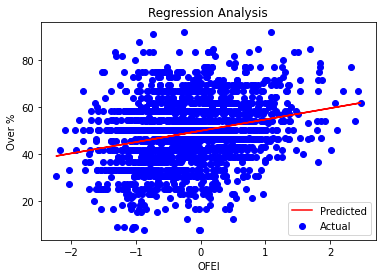

In [458]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Perform the regression analysis
X = merged_df[['OFEI']]
y = merged_df['Over %']
model = LinearRegression()
model.fit(X, y)

# Generate predictions
y_pred = model.predict(X)

# Plot the scatter plot and regression line
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='Predicted')
plt.xlabel('OFEI')
plt.ylabel('Over %')
plt.title('Regression Analysis')
plt.legend()
plt.show()

In [453]:
import statsmodels.api as sm

# Perform the regression analysis
X = sm.add_constant(merged_df['OFEI'])
y = merged_df['Over %']
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

2023-07-07 11:45:33 [py.warnings] WARNING: /Users/alecnigh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



                            OLS Regression Results                            
Dep. Variable:                 Over %   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     133.9
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           5.23e-30
Time:                        11:45:33   Log-Likelihood:                -7871.0
No. Observations:                1966   AIC:                         1.575e+04
Df Residuals:                    1964   BIC:                         1.576e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.8149      0.308    161.486      0.0

Now that we have all our regression information for Over's, let's do the same for Under's.

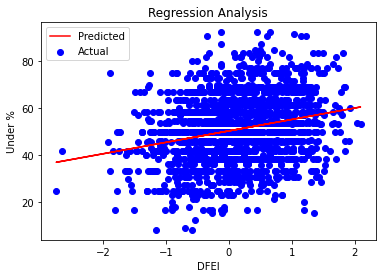

In [459]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Perform the regression analysis
X = merged_df[['DFEI']]
y = merged_df['Under %']
model = LinearRegression()
model.fit(X, y)

# Generate predictions
y_pred = model.predict(X)

# Plot the scatter plot and regression line
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='Predicted')
plt.xlabel('DFEI')
plt.ylabel('Under %')
plt.title('Regression Analysis')
plt.legend()
plt.show()

In [456]:
# Perform the regression analysis
X = sm.add_constant(merged_df['DFEI'])
y = merged_df['Under %']
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

2023-07-07 11:49:15 [py.warnings] WARNING: /Users/alecnigh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



                            OLS Regression Results                            
Dep. Variable:                Under %   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     130.4
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           2.73e-29
Time:                        11:49:15   Log-Likelihood:                -7872.5
No. Observations:                1966   AIC:                         1.575e+04
Df Residuals:                    1964   BIC:                         1.576e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.3702      0.306    164.760      0.0

# Regression Explanation

Overall, these regression results provide information about the significance and relationship between the independent variable (DFEI) and the dependent variable (Under %). The statistically significant coefficient for DFEI suggests that it has a significant effect on the dependent variable. However, the low R-squared value suggests that DFEI alone explains only a small portion of the variation in the dependent variable (6.2%), indicating that other factors may also influence the "Under %" outcome.

This table gives insights into the goodness of fit, significance of the independent variables, and other diagnostic statistics related to the linear regression model. It helps assess the strength and validity of the relationship between the dependent and independent variables in the regression analysis. The following is a breakdown of some of the different components of this analysis:

1. Model: The model used in this analysis is Ordinary Least Squares (OLS), which is a common method for estimating linear regression coefficients. This method aims to find the best-fitting line that minimizes the sum of squared differences between the observed points and predicted values.

2. R-squared: The R-squared value measures the proportion of the variance in the dependent variable that can be explained by the independent variable(s). In this case, the R-squared value is 0.062, indicating that approximately 6.2% of the variability in the "Under %" can be explained by the independent variable(s).

3. Adjusted R-squared: The adjusted R-squared value is a modified version of R-squared that takes into account the number of predictors in the model. It penalizes the inclusion of unnecessary variables. In this case, the adjusted R-squared value is also 0.062, which is the same as the R-squared value.

4. F-statistic: The F-statistic is used to test the overall significance of the model. It measures the ratio of the explained variance to the unexplained variance. A larger F-statistic suggests a more significant relationship between the independent variable(s) and the dependent variable. Here, the F-statistic is 130.4. To find the significance of our statstics, we need to look at the probabilty associated with the F-stat which is very low (2.73e-29), suggesting that the relationship between the independent variable and dependent variable is statisticslly significant.

5. Coefficients: The table shows the estimated coefficients for the independent variables. In this case, there are two coefficients: "Under %" and "DFEI". The "Under %" coefficient is 50.3702, and the "DFEI" coefficient is 4.8661. The 50.3702 number comes when the DFEI is exactly 0 -- aka an average defensive team will be under their total almost half the time. These coefficients represent the slopes of the regression line and indicate the change in the "Under %" for a one-unit change in the corresponding independent variable, holding other variables constant. For example, say we take an average Defensive team at (0,50.3701), and all else held constant, take a team that's 1 std above average at (1,y). Why is y not defined? Well, if we follow our regression line on our scatterplot, you'll see that by increasing 1 unit, there should be a 4.8661 increase in our y variable, thus, our point should be (1, 55.2363). In other words, teams with a DFEI at or above 1 are projected to be under the game total a little over 55% of the time.

6. Std err: The standard errors associated with the coefficients represent the precision of the coefficient estimates. Lower standard errors indicate more precise estimates.

7. t-values: The t-values are calculated by dividing the estimated coefficients by their standard errors. These values are used to test the significance of the coefficients. Here, the t-value for the "const" coefficient is 164.760, and for the "DFEI" coefficient is 11.420. Both coefficients have p-values less than 0.05, indicating they are statistically significant.

8. [0.025, 0.975]: These values represent the 95% confidence intervals for the coefficients. They provide a range within which the true population value of the coefficient is likely to fall with 95% confidence. In other words, most teams in most season would be expected to fall within 49-51%, which is too low to be profitable.

That section got pretty technical but I think it's important to understand what our regression analysis is demonstrating. The next section, we will see if the top 25% in OFEI and DFEI have any higher correlations compared to our other data.

# Top 25 %

Finally, let's take a look at the top quartile of offensive and defensive efficiency to see if the results are more predictive. First, we must find our thresholds for each using describe, and then we will subset our data.

In [464]:
merged_df[['OFEI','DFEI']].describe()

,OFEI,DFEI
count,1966.000000,1966.000000
mean,-0.181287,0.145234
std,0.721214,0.702795
min,-2.230000,-2.740000
25%,-0.690000,-0.340000
50%,-0.220000,0.145000
75%,0.300000,0.660000
max,2.470000,2.090000


In [474]:
ofei_subset = merged_df[merged_df['OFEI']>=0.3]
dfei_subset = merged_df[merged_df['DFEI']>=0.66]

2023-07-11 09:06:01 [py.warnings] WARNING: /Users/alecnigh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



                            OLS Regression Results                            
Dep. Variable:                 Over %   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     23.72
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           1.50e-06
Time:                        09:06:01   Log-Likelihood:                -1932.1
No. Observations:                 494   AIC:                             3868.
Df Residuals:                     492   BIC:                             3877.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.4695      1.167     41.527      0.0

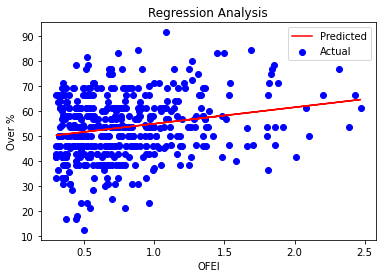

In [481]:
# Perform the regression analysis
Independent = sm.add_constant(ofei_subset['OFEI'])
dependent = ofei_subset['Over %']
model = sm.OLS(dependent, Independent)
results = model.fit()

# Print the regression results
print(results.summary())

# Perform the regression analysis
X = ofei_subset[['OFEI']]
y = ofei_subset['Over %']
model = LinearRegression()
model.fit(X, y)

# Generate predictions
y_pred = model.predict(X)

# Plot the scatter plot and regression line
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='Predicted')
plt.xlabel('OFEI')
plt.ylabel('Over %')
plt.title('Regression Analysis')
plt.legend()
plt.show()

2023-07-11 09:04:54 [py.warnings] WARNING: /Users/alecnigh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



                            OLS Regression Results                            
Dep. Variable:                Under %   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     7.333
Date:                Tue, 11 Jul 2023   Prob (F-statistic):            0.00701
Time:                        09:04:54   Log-Likelihood:                -1974.0
No. Observations:                 494   AIC:                             3952.
Df Residuals:                     492   BIC:                             3960.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.9143      2.197     22.268      0.0

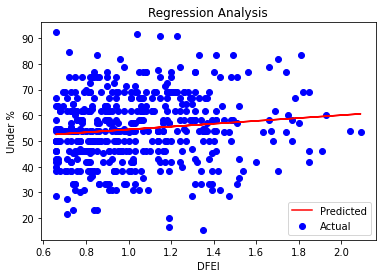

In [480]:
# Perform the regression analysis
Independent = sm.add_constant(dfei_subset['DFEI'])
dependent = dfei_subset['Under %']
model = sm.OLS(dependent, Independent)
results = model.fit()

# Print the regression results
print(results.summary())

# Perform the regression analysis
X = dfei_subset[['DFEI']]
y = dfei_subset['Under %']
model = LinearRegression()
model.fit(X, y)

# Generate predictions
y_pred = model.predict(X)

# Plot the scatter plot and regression line
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='Predicted')
plt.xlabel('DFEI')
plt.ylabel('Under %')
plt.title('Regression Analysis')
plt.legend()
plt.show()

This is more aligned with my thought process going into the project -- that the oddsmakers know when a team has a good offense (top 25%) or defense (top 25%), and they shade the lines accordingly. The public sees these teams on the extreme ends of the equation and figure (team x has a great defense, so they should be holding their opponents to low scores, and thus, more likely for an under). However, this is not the case.

The offensive efficiency stats explain a little more for an over than a strong defense and an under (4.6 vs 1.3). This could be due to higher possessions for both teams as the more explosive an offense is, the quicker they'll score, and the more possessions each team will have which would theoretically increase the score. These thoughts are outside the scope of this project, but interesting nevertheless. 

Our data did show that there's a positive correlation though. Let's see if the bottom 50% of both offensive and defensive efficiency is any more predictive than the top quarter, or the dataset as a whole.

# Bottom 50%

Finally, let's look at the bottom half and see if they have a significant inverse effect on the overs and unders. Our technique will be different here because we will pair our low offenses to Unders, and our poor defenses to Overs.

In [496]:
ofei_subset = merged_df[merged_df['OFEI']<=-(0.22)]
dfei_subset = merged_df[merged_df['DFEI']<=0.14]

2023-07-11 10:10:14 [py.warnings] WARNING: /Users/alecnigh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



                            OLS Regression Results                            
Dep. Variable:                Under %   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     20.14
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           8.02e-06
Time:                        10:10:14   Log-Likelihood:                -3986.8
No. Observations:                 990   AIC:                             7978.
Df Residuals:                     988   BIC:                             7987.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.6684      0.957     51.923      0.0

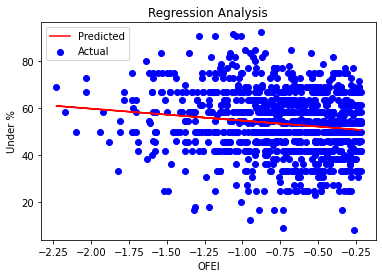

In [497]:
# Perform the regression analysis
Independent = sm.add_constant(ofei_subset['OFEI'])
dependent = ofei_subset['Under %']
model = sm.OLS(dependent, Independent)
results = model.fit()

# Print the regression results
print(results.summary())

# Perform the regression analysis
X = ofei_subset[['OFEI']]
y = ofei_subset['Under %']
model = LinearRegression()
model.fit(X, y)

# Generate predictions
y_pred = model.predict(X)

# Plot the scatter plot and regression line
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='Predicted')
plt.xlabel('OFEI')
plt.ylabel('Under %')
plt.title('Regression Analysis')
plt.legend()
plt.show()

2023-07-11 10:10:14 [py.warnings] WARNING: /Users/alecnigh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



                            OLS Regression Results                            
Dep. Variable:                 Over %   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     31.68
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           2.37e-08
Time:                        10:10:14   Log-Likelihood:                -3941.8
No. Observations:                 983   AIC:                             7888.
Df Residuals:                     981   BIC:                             7897.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.4915      0.597     82.883      0.0

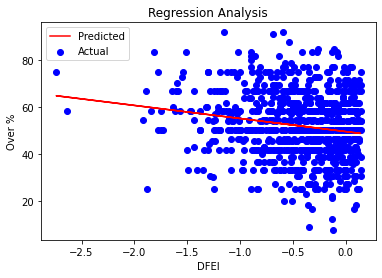

In [498]:
# Perform the regression analysis
Independent = sm.add_constant(dfei_subset['DFEI'])
dependent = dfei_subset['Over %']
model = sm.OLS(dependent, Independent)
results = model.fit()

# Print the regression results
print(results.summary())

# Perform the regression analysis
X = dfei_subset[['DFEI']]
y = dfei_subset['Over %']
model = LinearRegression()
model.fit(X, y)

# Generate predictions
y_pred = model.predict(X)

# Plot the scatter plot and regression line
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='Predicted')
plt.xlabel('DFEI')
plt.ylabel('Over %')
plt.title('Regression Analysis')
plt.legend()
plt.show()

I contemplated elimating these sections as they did not add a lot to our analysis, but I do think it's important to publish findings even if they aren't riveting. In a way, there is something to be gleaned by a fruitless experiment, as unexciting as it may be.  

# Conclusion

Well, it turns out there's not too much value to be made around the edges. Ultimatley, one should look elsewhere in order to find out which teams are more likely to be a safe over play or an under play. Be careful not to assume any team with a strong offense will immediately be a strong over play. It turns out the oddsmakers are pretty smart at what they do. All of this goes back to the age old adage that "you don't bet the team, but the line".

Thanks for taking the time to read and happy handicapping!